# 영산강 주별 통합 데이터

- 지역: '1_평동천', '2_광산', '3_장성천2', '4_문평천', '5_영산포2', '6_함평', '7_무안2'
- 그레이디언트부스팅 기법으로 클로로필 a에 영향을 주는 주요 특성 확인

**필수 라이브러리**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

**matplotlib 한글 설정**

- 운영체제에 따른 한글 지원 설정. 윈도우, 우분투, 구글 코랩 지원.
- 참고: [matplotlib에서 한글 지원하기](https://github.com/codingalzi/datapy/blob/master/matplotlib-korean.md)

In [2]:
import platform
plt.rc('figure', figsize=(10, 6))  # 그림 크기 설정
if platform.system() == 'Windows': # 윈도우
    from matplotlib import font_manager, rc
    font_path = "C:/Windows/Fonts/NGULIM.TTF"
    font = font_manager.FontProperties(fname=font_path).get_name()
    rc('font', family=font)
elif platform.system() == 'Linux': # 우분투 또는 구글 코랩
    # !sudo apt-get install -y fonts-nanum*
    # !fc-cache -fv
    
    applyfont = "NanumBarunGothic"
    import matplotlib.font_manager as fm
    if not any(map(lambda ft: ft.name == applyfont, fm.fontManager.ttflist)):
        fm.fontManager.addfont("/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf")
    plt.rc("font", family=applyfont)
    plt.rc("axes", unicode_minus=False)

In [3]:
base_path = "https://github.com/codingalzi/water-data/raw/master/reservoirs/"
# base_path = r"C:\Users\owner\Desktop\water-source\data"

In [4]:
ysr_yearly = pd.read_excel(base_path+"Yeongsan_weekly_total.xlsx", 
# ysr_yearly = pd.read_excel(base_path+"영산강 통합 데이터.xlsx", 
                            skiprows=0, 
                            sheet_name=None,
                            na_values='ND',
                            parse_dates=True)  # index_col=0, header=1을 제외함

In [5]:
ysr_yearly.keys()

dict_keys(['1_평동천', '2_광산', '3_장성천2', '4_문평천', '5_영산포2', '6_함평', '7_무안2'])

결측치는 모두 0으로.

In [6]:
for location in ysr_yearly:
    ysr_yearly[location].fillna(0, inplace=True)

## 특성별 타임스텝 추가

- `dict` 자료형의 `copy()` 함수는 shallow 복사.

In [7]:
import copy
ysr_yearly_pre = copy.deepcopy(ysr_yearly)

shift 컬럼을 사전으로 모은 후 `concat()` 로 합치는 게 훨씬 빠름.

In [8]:
for location in ysr_yearly_pre:
    loc = dict()
    
    for i in range(1, 49):
        loc[str(i) + 'shift_수온'] = ysr_yearly_pre[location]['수온(℃)'].shift(i)
        loc[str(i) + 'shift_BOD'] = ysr_yearly_pre[location]['BOD(㎎/L)'].shift(i)
        loc[str(i) + 'shift_COD'] = ysr_yearly_pre[location]['COD(㎎/L)'].shift(i)
        loc[str(i) + 'shift_TN'] = ysr_yearly_pre[location]['TN(㎎/L)'].shift(i)
        loc[str(i) + 'shift_TP'] = ysr_yearly_pre[location]['TP(㎎/L)'].shift(i)
        loc[str(i) + 'shift_유량'] = ysr_yearly_pre[location]['유량(㎥/s)'].shift(i)

    loc = pd.DataFrame(loc)
    ysr_yearly_pre[location] = pd.concat([ysr_yearly_pre[location], loc], axis=1)

In [9]:
for location in ysr_yearly_pre:
    print(ysr_yearly_pre[location].shape)

(440, 308)
(510, 308)
(435, 308)
(435, 308)
(456, 308)
(456, 308)
(534, 308)


In [10]:
df = pd.DataFrame()

for location in ysr_yearly_pre:
    df = pd.concat([df, ysr_yearly_pre[location]])

In [11]:
df.columns

Index(['측정소명', '년/월/일', '회차', '수온(℃)', 'DO(㎎/L)', 'BOD(㎎/L)', 'COD(㎎/L)',
       '클로로필 a(㎎/㎥)', 'TN(㎎/L)', 'TP(㎎/L)',
       ...
       '47shift_COD', '47shift_TN', '47shift_TP', '47shift_유량', '48shift_수온',
       '48shift_BOD', '48shift_COD', '48shift_TN', '48shift_TP', '48shift_유량'],
      dtype='object', length=308)

In [12]:
df1 = df.reset_index(drop=True).join(pd.get_dummies(df['측정소명']).reset_index(drop=True))

In [13]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3266 entries, 0 to 3265
Columns: 315 entries, 측정소명 to 함평
dtypes: datetime64[ns](1), float64(304), int64(1), object(2), uint8(7)
memory usage: 7.7+ MB


In [14]:
col10 = list(df.columns[3:20])

In [15]:
col = list(df1.columns[3:4]) + list(df1.columns[5:10]) + list(df1.columns[19:]) 

In [16]:
col10[4]

'클로로필 a(㎎/㎥)'

In [17]:
from sklearn.preprocessing import StandardScaler

In [18]:
df_ysr = df1.loc[:, col10]

In [19]:
df_ysr

,수온(℃),DO(㎎/L),BOD(㎎/L),COD(㎎/L),클로로필 a(㎎/㎥),TN(㎎/L),TP(㎎/L),TOC(㎎/L),수소이온농도,전기전도도(μS/㎝),용존총질소(㎎/L),암모니아성 질소(㎎/L),질산성 질소(㎎/L),용존총인(㎎/L),인산염인(㎎/L),SS(㎎/L),유량(㎥/s)
0,24.5,8.1,6.3,12.5,0.0,2.903,0.195,8.7,7.6,229,0.000,0.000,0.000,0.000,0.000,61.7,0.519
1,25.1,7.2,5.9,12.8,0.0,3.628,0.149,9.9,6.8,275,0.000,0.000,0.000,0.000,0.000,20.0,0.200
2,23.0,7.8,5.6,10.5,0.0,2.939,0.143,6.7,6.8,193,0.000,0.000,0.000,0.000,0.000,54.7,0.795
3,24.9,7.7,5.6,11.1,0.0,2.807,0.144,7.9,7.5,264,0.000,0.000,0.000,0.000,0.000,42.8,0.282
4,24.7,5.7,2.1,12.5,0.0,2.737,0.051,5.7,7.3,290,0.000,0.000,0.000,0.000,0.000,15.0,0.213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3261,22.7,8.6,2.9,7.7,5.9,3.598,0.043,4.9,7.9,2482,3.412,0.162,2.510,0.028,0.012,4.3,141.215
3262,22.8,9.6,3.0,8.0,18.8,3.254,0.050,6.0,8.4,2477,2.957,0.076,2.289,0.024,0.000,9.0,287.252
3263,24.0,11.9,2.6,8.6,17.7,2.843,0.044,6.7,8.6,2033,2.676,0.022,1.883,0.033,0.000,9.4,0.000
3264,24.6,9.7,1.6,8.4,10.1,2.433,0.025,7.0,9.0,2305,2.267,0.011,1.658,0.014,0.000,6.3,115.604


In [20]:
df_ysr.columns[4]

'클로로필 a(㎎/㎥)'

In [21]:
col10[4]

'클로로필 a(㎎/㎥)'

In [22]:
scaler = StandardScaler()
scaler.fit(df_ysr)
ysr_scaled = scaler.transform(df_ysr)

ysr_df_scaled = pd.DataFrame(data = ysr_scaled, columns = col10)

In [23]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
import seaborn as sns

In [24]:
col_v = col10[:4] + col10[5:]

In [25]:
col100 = list(ysr_yearly['2_광산'].columns[3:])

In [26]:
col100_v = col100[:4] + col100[5:]

In [27]:
dfdf = ysr_yearly['2_광산'].fillna(0)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(dfdf.loc[:, col100_v], dfdf['클로로필 a(㎎/㎥)'], random_state=42)
gb_reg = GradientBoostingRegressor(max_depth=5, n_estimators=500, learning_rate=0.01, random_state=42)
gb_reg.fit(X_train, np.log1p(y_train))


for score, name in zip(gb_reg.feature_importances_, col_v):
    print(round(score, 2), name)
print('score :', gb_reg.score(X_test, np.log1p(y_test)))

0.05 수온(℃)
0.05 DO(㎎/L)
0.38 BOD(㎎/L)
0.09 COD(㎎/L)
0.01 TN(㎎/L)
0.02 TP(㎎/L)
0.04 TOC(㎎/L)
0.01 수소이온농도
0.09 전기전도도(μS/㎝)
0.02 용존총질소(㎎/L)
0.03 암모니아성 질소(㎎/L)
0.01 질산성 질소(㎎/L)
0.03 용존총인(㎎/L)
0.1 인산염인(㎎/L)
0.06 SS(㎎/L)
0.03 유량(㎥/s)
score : 0.7675342203674818


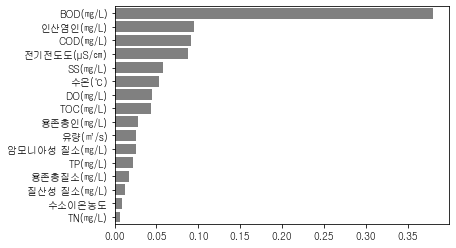

In [29]:
feature_series = pd.Series(data = gb_reg.feature_importances_, index = col_v)
feature_series = feature_series.sort_values(ascending = False)
sns.barplot(x = feature_series, y = feature_series.index, color = 'gray')
plt.show()

In [30]:
X_train, X_test, y_train, y_test = train_test_split(ysr_df_scaled.loc[:, col_v], ysr_df_scaled['클로로필 a(㎎/㎥)'], random_state=42)
gb_reg = GradientBoostingRegressor(max_depth=5, n_estimators=500, learning_rate=0.01, random_state=42)
gb_reg.fit(X_train, np.log1p(y_train))


for score, name in zip(gb_reg.feature_importances_, col_v):
    print(round(score, 2), name)
print('score :', gb_reg.score(X_test, np.log1p(y_test)))

0.02 수온(℃)
0.04 DO(㎎/L)
0.45 BOD(㎎/L)
0.05 COD(㎎/L)
0.01 TN(㎎/L)
0.01 TP(㎎/L)
0.01 TOC(㎎/L)
0.03 수소이온농도
0.03 전기전도도(μS/㎝)
0.02 용존총질소(㎎/L)
0.01 암모니아성 질소(㎎/L)
0.02 질산성 질소(㎎/L)
0.04 용존총인(㎎/L)
0.06 인산염인(㎎/L)
0.03 SS(㎎/L)
0.18 유량(㎥/s)
score : 0.771705172783351


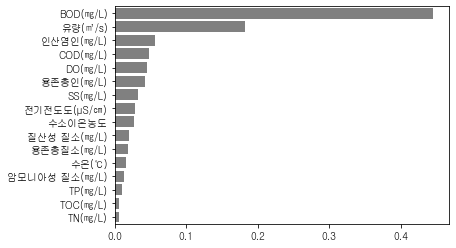

In [31]:
feature_series = pd.Series(data = gb_reg.feature_importances_, index = col_v)
feature_series = feature_series.sort_values(ascending = False)
sns.barplot(x = feature_series, y = feature_series.index, color = 'gray')
plt.show()

In [32]:
X_train, X_test, y_train, y_test = train_test_split(ysr_df_scaled.loc[:, col_v], ysr_df_scaled['클로로필 a(㎎/㎥)'], random_state=42)
gb_reg = GradientBoostingRegressor(max_depth=5, n_estimators=500, learning_rate=0.02, random_state=42)
gb_reg.fit(X_train, np.log1p(y_train))


for score, name in zip(gb_reg.feature_importances_, col_v):
    print(round(score, 2), name)
print('score :', gb_reg.score(X_test, np.log1p(y_test)))

0.02 수온(℃)
0.04 DO(㎎/L)
0.43 BOD(㎎/L)
0.05 COD(㎎/L)
0.01 TN(㎎/L)
0.01 TP(㎎/L)
0.01 TOC(㎎/L)
0.03 수소이온농도
0.03 전기전도도(μS/㎝)
0.02 용존총질소(㎎/L)
0.02 암모니아성 질소(㎎/L)
0.02 질산성 질소(㎎/L)
0.04 용존총인(㎎/L)
0.06 인산염인(㎎/L)
0.03 SS(㎎/L)
0.18 유량(㎥/s)
score : 0.775832481330609


In [33]:
X_train, X_test, y_train, y_test = train_test_split(ysr_df_scaled.loc[:, col_v], ysr_df_scaled['클로로필 a(㎎/㎥)'], random_state=42)
gb_reg = GradientBoostingRegressor(max_depth=5, n_estimators=500, learning_rate=0.03, random_state=42)
gb_reg.fit(X_train, np.log1p(y_train))


for score, name in zip(gb_reg.feature_importances_, col_v):
    print(round(score, 2), name)
print('score :', gb_reg.score(X_test, np.log1p(y_test)))

0.02 수온(℃)
0.04 DO(㎎/L)
0.42 BOD(㎎/L)
0.05 COD(㎎/L)
0.01 TN(㎎/L)
0.01 TP(㎎/L)
0.01 TOC(㎎/L)
0.03 수소이온농도
0.03 전기전도도(μS/㎝)
0.02 용존총질소(㎎/L)
0.02 암모니아성 질소(㎎/L)
0.03 질산성 질소(㎎/L)
0.04 용존총인(㎎/L)
0.05 인산염인(㎎/L)
0.04 SS(㎎/L)
0.18 유량(㎥/s)
score : 0.7779531551282586


In [34]:
X_train, X_test, y_train, y_test = train_test_split(ysr_df_scaled.loc[:, col_v], ysr_df_scaled['클로로필 a(㎎/㎥)'], random_state=42)
gb_reg = GradientBoostingRegressor(max_depth=5, n_estimators=500, learning_rate=0.1, random_state=42)
gb_reg.fit(X_train, np.log1p(y_train))


for score, name in zip(gb_reg.feature_importances_, col_v):
    print(round(score, 2), name)
print('score :', gb_reg.score(X_test, np.log1p(y_test)))

0.02 수온(℃)
0.05 DO(㎎/L)
0.4 BOD(㎎/L)
0.05 COD(㎎/L)
0.01 TN(㎎/L)
0.02 TP(㎎/L)
0.01 TOC(㎎/L)
0.03 수소이온농도
0.03 전기전도도(μS/㎝)
0.03 용존총질소(㎎/L)
0.02 암모니아성 질소(㎎/L)
0.03 질산성 질소(㎎/L)
0.04 용존총인(㎎/L)
0.05 인산염인(㎎/L)
0.04 SS(㎎/L)
0.17 유량(㎥/s)
score : 0.7807469595513825


In [35]:
X_train, X_test, y_train, y_test = train_test_split(ysr_df_scaled.loc[:, col_v], ysr_df_scaled['클로로필 a(㎎/㎥)'], random_state=42)
gb_reg = GradientBoostingRegressor(max_depth=5, n_estimators=500, learning_rate=0.1, random_state=42)
gb_reg.fit(X_train, np.log1p(y_train))


for score, name in zip(gb_reg.feature_importances_, col_v):
    print(round(score, 2), name)
print('score :', gb_reg.score(X_test, np.log1p(y_test)))

0.02 수온(℃)
0.05 DO(㎎/L)
0.4 BOD(㎎/L)
0.05 COD(㎎/L)
0.01 TN(㎎/L)
0.02 TP(㎎/L)
0.01 TOC(㎎/L)
0.03 수소이온농도
0.03 전기전도도(μS/㎝)
0.03 용존총질소(㎎/L)
0.02 암모니아성 질소(㎎/L)
0.03 질산성 질소(㎎/L)
0.04 용존총인(㎎/L)
0.05 인산염인(㎎/L)
0.04 SS(㎎/L)
0.17 유량(㎥/s)
score : 0.7807469595513825


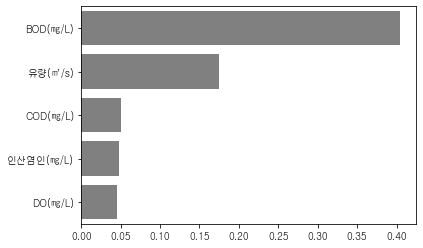

In [36]:
feature_series = pd.Series(data = gb_reg.feature_importances_, index = col_v)
feature_series = feature_series.sort_values(ascending = False)
sns.barplot(x = feature_series[:5], y = feature_series.index[:5], color = 'gray')
plt.show()

In [37]:
predict_x = (np.expm1(gb_reg.predict(X_test)) * df1['클로로필 a(㎎/㎥)'].std() + df1['클로로필 a(㎎/㎥)'].mean())

In [38]:
real_val = (y_test * df1['클로로필 a(㎎/㎥)'].std() + df1['클로로필 a(㎎/㎥)'].mean())

In [39]:
len(sorted(abs(predict_x - real_val), reverse=True))

817

In [40]:
sorted(abs(predict_x - real_val), reverse=True)[:10]

[125.13271547989171,
 82.21443614015303,
 76.68805725016443,
 65.34375825208213,
 61.12820772839689,
 61.03053230076399,
 58.96547899372288,
 57.79889320776567,
 55.42853692990542,
 55.21845373722901]

In [41]:
abs(predict_x - real_val)[abs(predict_x - real_val) == 121.01861172755656]

Series([], Name: 클로로필 a(㎎/㎥), dtype: float64)

In [42]:
real_val[887]  # 예측값 110 정도..

230.83128726673053

In [43]:
abs(predict_x - real_val)[abs(predict_x - real_val) == 111.31006053388529]

Series([], Name: 클로로필 a(㎎/㎥), dtype: float64)

In [44]:
real_val[889]  # 예측값 93 정도..

204.7272906355149

In [45]:
df1[880:895]

,측정소명,년/월/일,회차,수온(℃),DO(㎎/L),BOD(㎎/L),COD(㎎/L),클로로필 a(㎎/㎥),TN(㎎/L),TP(㎎/L),...,48shift_TN,48shift_TP,48shift_유량,광산,무안2,문평천,영산포2,장성천2,평동천,함평
880,광산,2020-08-03,1회차,25.3,6.5,3.9,5.7,5.2,3.169,0.154,...,3.330,0.102,27.340,1,0,0,0,0,0,0
881,광산,2020-08-19,2회차,29.7,7.9,4.3,7.8,57.5,3.472,0.180,...,3.690,0.078,0.000,1,0,0,0,0,0,0
882,광산,2020-08-24,3회차,29.3,7.0,4.7,8.2,45.3,4.240,0.110,...,3.045,0.238,46.592,1,0,0,0,0,0,0
883,광산,2020-09-01,1회차,28.3,6.1,4.8,8.0,24.1,2.511,0.218,...,3.832,0.072,20.979,1,0,0,0,0,0,0
884,광산,2020-09-08,2회차,21.5,7.4,3.7,6.4,4.2,2.218,0.172,...,2.883,0.162,73.722,1,0,0,0,0,0,0
885,광산,2020-09-14,3회차,23.3,7.2,3.1,5.4,6.0,2.545,0.144,...,3.606,0.093,27.399,1,0,0,0,0,0,0
886,광산,2020-09-21,4회차,22.7,10.9,4.5,8.3,71.5,2.948,0.091,...,3.397,0.079,43.254,1,0,0,0,0,0,0
887,광산,2020-09-28,5회차,23.5,13.5,6.8,13.5,230.8,4.192,0.083,...,3.984,0.055,27.438,1,0,0,0,0,0,0
888,광산,2020-10-05,1회차,22.2,10.5,5.4,11.7,184.4,4.236,0.094,...,4.452,0.060,20.164,1,0,0,0,0,0,0
889,광산,2020-10-12,2회차,21.2,13.9,4.5,12.9,204.7,4.549,0.113,...,4.791,0.056,8.700,1,0,0,0,0,0,0


In [46]:
ysr_yearly['2_광산'][ysr_yearly['2_광산']['클로로필 a(㎎/㎥)'] > 200]

,측정소명,년/월/일,회차,수온(℃),DO(㎎/L),BOD(㎎/L),COD(㎎/L),클로로필 a(㎎/㎥),TN(㎎/L),TP(㎎/L),TOC(㎎/L),수소이온농도,전기전도도(μS/㎝),용존총질소(㎎/L),암모니아성 질소(㎎/L),질산성 질소(㎎/L),용존총인(㎎/L),인산염인(㎎/L),SS(㎎/L),유량(㎥/s)
447,광산,2020-09-28,5회차,23.5,13.5,6.8,13.5,230.8,4.192,0.083,7.0,8.7,322,3.904,1.247,1.773,0.019,0.002,22.9,17.855
449,광산,2020-10-12,2회차,21.2,13.9,4.5,12.9,204.7,4.549,0.113,4.6,8.9,356,3.986,1.105,2.054,0.019,0.007,24.7,16.995
474,광산,2021-04-12,2회차,17.4,12.4,6.9,12.3,224.1,4.740,0.170,4.8,8.2,324,4.187,1.352,2.099,0.028,0.008,24.4,20.078
475,광산,2021-04-19,3회차,15.2,14.2,6.8,13.6,228.3,5.668,0.166,4.5,8.3,341,4.707,1.614,2.456,0.029,0.004,22.7,11.673
